In [1]:
# --------------------------------------------------------
# Pytorch multi-GPU Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Jiasen Lu, Jianwei Yang, based on code from Ross Girshick
# --------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import numpy.random as npr
import argparse
import pprint
import pdb
import time
import random

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler
from torch.utils.data.sampler import BatchSampler

from roi_data_layer.roidb_VID import combined_roidb_VID
from roi_data_layer.roibatchLoader_VID import roibatchLoader_VID
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.utils.net_utils import weights_normal_init, save_net, load_net, \
      adjust_learning_rate, save_checkpoint, clip_gradient

#from model.faster_rcnn.vgg16 import vgg16
#from model.faster_rcnn.resnet import resnet
from model.faster_rcnn.faster_rcnn import _fasterRCNN
from easydict import EasyDict
torch.cuda.set_device(0)
def parse_args():
    """
    Parse input arguments
    """
    args = EasyDict()
    args['dataset'] = 'imagenetVID_1_vid'
    args['net'] = 'res101'
    args['start_epoch'] = 1
    args['max_epochs'] = 1
    args['disp_interval'] = 1
    args['checkpoint_interval'] = 10000
    args['save_dir'] = 'models'
    args['num_workers'] = 1
    args['cuda'] = True
    args['large_scale'] = False
    args['mGPUs'] = False
    args['batch_size'] = 2
    args['vid_size'] = 1
    args['class_agnostic'] = False
    args['optimizer'] = 'sgd'
    args['lr'] = 0.001
    args['lr_decay_step'] = 5
    args['lr_decay_gamma'] = 0.1
    args['session'] = 1
    args['resume'] = True
    args['checksession'] = 1
    args['checkepoch'] = 8
    args['checkpoint'] = 27452
    args['cfg_file'] = 'cfgs/res101_lighthead.yml'
    args['no_save'] = True

    return args

class batchSampler(BatchSampler):
    def __init__(self, sampler, batch_size):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        self.sampler = sampler
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)  # Difference: batch.append(int(idx))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler) / self.batch_size


class sampler_imagenet_VID(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 100):
        '''
        This sampler samples batches from 1 video every time.
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = sample_gap_upper_bound/lmdb._gap
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []
        while counter<train_size:
            # First, we sample the videos from each category.
            cat_idxs = list(range(30))
            sampled_vids_for_each_category = []
            for cat_idx in cat_idxs:
                vids = structured_indexes[cat_idx]
                if len(vids)>0:
                    sampled_vids = random.sample(vids, vid_per_cat)
                    sampled_vids_for_each_category.append(sampled_vids)
                else:
                    sampled_vids_for_each_category.append([])
            # Next, we generate training sample indexes.
            for vid_id in range(vid_per_cat):
                cat_idxs = list(range(30))
                random.shuffle(cat_idxs)
                for cat_idx in cat_idxs:
                    vids = sampled_vids_for_each_category[cat_idx]
                    if len(vids)>0:
                        vid = vids[vid_id]
                        for _ in range(batch_size):
                            item = random.sample(vid, 2)
                            while item[0]-item[1]>self._index_gap_upper_bound or item[1]-item[0]>self._index_gap_upper_bound:
                                item = random.sample(vid, 2)
                            samples.append(item)
                            counter+=1
        self.samples = samples[:train_size]

    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

def create_tensor_holder():
    # initilize the tensor holder here.
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)

    # ship to cuda
    if args.cuda:
        im_data = im_data.cuda()
        im_info = im_info.cuda()
        num_boxes = num_boxes.cuda()
        gt_boxes = gt_boxes.cuda()

    # make variable
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)
    return im_data,im_info,num_boxes,gt_boxes

def get_CNN_params(model, lr):
    params = []
    for key, value in dict(model.named_parameters()).items():
        if value.requires_grad:
            if 'bias' in key:
                params += [{'params': [value], 'lr': lr * (cfg.TRAIN.DOUBLE_BIAS + 1),
                            'weight_decay': cfg.TRAIN.BIAS_DECAY and cfg.TRAIN.WEIGHT_DECAY or 0}]
            else:
                params += [{'params': [value], 'lr': lr, 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}]
    return params

import cPickle
import cPickle
import cPickle


In [2]:
args = parse_args()

print('Called with args:')
print(args)

if args.dataset == "imagenet":
    args.imdb_name = "imagenet_train"
    args.imdbval_name = "imagenet_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenet_10_imgs":
    args.imdb_name = "imagenet_10_imgs_train"
    args.imdbval_name = "imagenet_10_imgs_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID_1_vid":
    args.imdb_name = 'imagenetVID_1_vid_train'
    args.imdbval_name = 'imagenetVID_1_vid_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID":
    args.imdb_name = 'imagenetVID_train'
    args.imdbval_name = 'imagenetVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == 'imagenetDETVID':
    args.imdb_name = 'imagenetDETVID_train'
    args.imdbval_name = 'imagenetDETVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']

if args.cfg_file is None:
    args.cfg_file = "cfgs/{}_ls.yml".format(args.net) if args.large_scale else "cfgs/{}.yml".format(args.net)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

print('Using config:')
pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)

#torch.backends.cudnn.benchmark = True
if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# train set
# -- Note: Use validation set and disable the flipped to enable faster loading.
cfg.TRAIN.USE_FLIPPED = False
cfg.USE_GPU_NMS = args.cuda
# TODO change combined_roidb.
imdb, roidb, ratio_list, ratio_index = combined_roidb_VID(args.imdb_name)

print('{:d} roidb entries'.format(len(roidb)))

output_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# TODO change the dataloader and sampler.
train_size = 150
my_sampler = sampler_imagenet_VID(
    train_size = train_size, 
    lmdb=imdb, 
    batch_size=args.batch_size, 
    vid_per_cat = 1, 
    sample_gap_upper_bound = 100)
my_batch_sampler = batchSampler(sampler = my_sampler, batch_size=args.batch_size)

dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, args.batch_size, imdb.num_classes, training=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=my_batch_sampler, num_workers=args.num_workers)

if args.cuda:
    cfg.CUDA = True

# initilize the network here.
if args.net == 'res101':
    RCNN = _fasterRCNN(imdb.classes, 101, pretrained=True, class_agnostic=args.class_agnostic, b_save_mid_convs = True)
elif args.net == 'res50':
    RCNN = _fasterRCNN(imdb.classes, 50, pretrained=True, class_agnostic=args.class_agnostic, b_save_mid_convs = True)
elif args.net == 'res152':
    RCNN = _fasterRCNN(imdb.classes, 152, pretrained=True, class_agnostic=args.class_agnostic, b_save_mid_convs = True)
else:
    print("network is not defined")
    pdb.set_trace()

RCNN.create_architecture()

lr = cfg.TRAIN.LEARNING_RATE
lr = args.lr
#tr_momentum = cfg.TRAIN.MOMENTUM
#tr_momentum = args.momentum

params = []
params = get_CNN_params(RCNN, lr)

if args.optimizer == "adam":
    lr = lr * 0.1
    optimizer = torch.optim.Adam(params)

elif args.optimizer == "sgd":
    optimizer = torch.optim.SGD(params, momentum=cfg.TRAIN.MOMENTUM)

if args.cuda:
    RCNN.cuda()

if args.resume:
    load_name_predix = cfg.RESNET.CORE_CHOICE.USE
    if cfg.TRAIN.OHEM is True:
        load_name_predix = load_name_predix + '_OHEM'
    prefix = args.save_dir + "/" + args.net + "/" +'imagenetDETVID'
    load_name = os.path.join(
        prefix,
        load_name_predix+'_{}_{}_{}.pth'.format(args.checksession, args.checkepoch, args.checkpoint))
print("loading checkpoint %s" % (load_name))
checkpoint = torch.load(load_name)
args.session = checkpoint['session']
args.start_epoch = checkpoint['epoch']
RCNN.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr = optimizer.param_groups[0]['lr']
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']
print("loaded checkpoint %s" % (load_name))

if args.mGPUs:
    RCNN = nn.DataParallel(RCNN)

iters_per_epoch = int(train_size / args.batch_size)

im_data_1, im_info_1, num_boxes_1, gt_boxes_1 = create_tensor_holder()
im_data_2, im_info_2, num_boxes_2, gt_boxes_2 = create_tensor_holder()
####for epoch in range(args.start_epoch, args.max_epochs + 1):
# setting to train mode
RCNN.train()
loss_temp = 0
start = time.time()

Called with args:
{'checksession': 1, 'cfg_file': 'cfgs/res101_lighthead.yml', 'start_epoch': 1, 'dataset': 'imagenetVID_1_vid', 'session': 1, 'max_epochs': 1, 'mGPUs': False, 'disp_interval': 1, 'resume': True, 'checkpoint': 27452, 'lr': 0.001, 'net': 'res101', 'cuda': True, 'optimizer': 'sgd', 'num_workers': 1, 'batch_size': 2, 'checkepoch': 8, 'lr_decay_step': 5, 'vid_size': 1, 'no_save': True, 'large_scale': False, 'lr_decay_gamma': 0.1, 'save_dir': 'models', 'checkpoint_interval': 10000, 'class_agnostic': False}
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'res101',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 30,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECA

lib/model/utils/config.py:419: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


Loading pretrained weights from data/pretrained_model/resnet101_caffe.pth
loading checkpoint models/res101/imagenetDETVID/rfcn_light_head_1_8_27452.pth
loaded checkpoint models/res101/imagenetDETVID/rfcn_light_head_1_8_27452.pth


In [4]:
data_iter = iter(dataloader)
####for step in range(iters_per_epoch):
data_1, data_2 = next(data_iter)

im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])

print(im_data_1.shape)
#print(im_data.shape)
RCNN.zero_grad()
##################################
#        Detection part          #
##################################
# detection loss for image 1.
rois_1, cls_prob_1, bbox_pred_1, \
rpn_loss_cls_1, rpn_loss_box_1, \
RCNN_loss_cls_1, RCNN_loss_bbox_1, \
rois_label_1 = RCNN(im_data_1, im_info_1, gt_boxes_1, num_boxes_1)

#c3_1, c4_1, c5_1 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_1 = RCNN.Conv4_feat
rpn_rois_1 = RCNN.rpn_rois

loss = rpn_loss_cls_1.mean() + rpn_loss_box_1.mean() \
   + RCNN_loss_cls_1.mean() + RCNN_loss_bbox_1.mean()

# detection loss for image 2.
rois_2, cls_prob_2, bbox_pred_2, \
rpn_loss_cls_2, rpn_loss_box_2, \
RCNN_loss_cls_2, RCNN_loss_bbox_2, \
rois_label_2 = RCNN(im_data_2, im_info_2, gt_boxes_2, num_boxes_2)

#c3_2, c4_2, c5_2 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_2 = RCNN.Conv4_feat
rpn_rois_2 = RCNN.rpn_rois

# beware, need to use += operation here.
loss += rpn_loss_cls_2.mean() + rpn_loss_box_2.mean() \
     + RCNN_loss_cls_2.mean() + RCNN_loss_bbox_2.mean()

##################################
#        Tracking part           #
##################################
# define tracking loss here.

loss_temp += loss.item()

'''
# backward
optimizer.zero_grad()
loss.backward()
if args.net == "vgg16":
    clip_gradient(RCNN, 10.)
optimizer.step()

if step % args.disp_interval == 0:
    end = time.time()
    if step > 0:
        loss_temp /= (args.disp_interval + 1)

    if args.mGPUs:
        loss_rpn_cls = rpn_loss_cls.mean().item()
        loss_rpn_box = rpn_loss_box.mean().item()
        loss_rcnn_cls = RCNN_loss_cls.mean().item()
        loss_rcnn_box = RCNN_loss_bbox.mean().item()
        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt
    else:
        loss_rpn_cls = rpn_loss_cls.item()
        loss_rpn_box = rpn_loss_box.item()
        loss_rcnn_cls = RCNN_loss_cls.item()
        loss_rcnn_box = RCNN_loss_bbox.item()
        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt

    print("[session %d][epoch %2d][iter %4d/%4d] loss: %.4f, lr: %.2e" \
                            % (args.session, epoch, step, iters_per_epoch, loss_temp, lr))
    print("\t\t\tfg/bg=(%d/%d), time cost: %f" % (fg_cnt, bg_cnt, end-start))
    print("\t\t\trpn_cls: %.4f, rpn_box: %.4f, rcnn_cls: %.4f, rcnn_box %.4f" \
                  % (loss_rpn_cls, loss_rpn_box, loss_rcnn_cls, loss_rcnn_box))

    loss_temp = 0
    start = time.time()
'''


tensor([ 1,  1], device='cuda:0')

#### Examine the data shapes.

In [7]:
print(conv4_feat_1.shape)
print(rpn_rois_1.shape)
print(conv4_feat_2.shape)
print(rpn_rois_2.shape)

torch.Size([2, 1024, 38, 67])
torch.Size([2, 2000, 5])
torch.Size([2, 1024, 38, 67])
torch.Size([2, 2000, 5])


#### Test siamese RPN data preparation.

In [3]:
#from siamese_net.siameseRPN import siameseRPN
#from siamese_net.template_proposal_layer import _TemplateProposalLayer
#from siamese_net.template_target_proposal_layer import _TemplateTargetProposalLayer

In [3]:
cfg.SIAMESE.TEMPLATE_SZ = 5

In [4]:
# propose template images.
import torch
import torch.nn as nn
import numpy as np
from model.utils.config import cfg
from model.rpn.bbox_transform import bbox_overlaps_batch, bbox_transform_batch

class _TemplateProposalLayer(nn.Module):
    '''
    Propose template for siamese RPN.
    The functionality of this layer for training and testing are different.
    For training, it selects training samples from RPN output.
    The returned rois and track_ids are used for training sample preparation.
    For testing, it selects predicted boxes with high enough score.
    '''
    def __init__(self):
        super(_TemplateProposalLayer, self).__init__()

    def forward(self, inputs):
        if self.training:
            all_rois, gt_boxes = inputs
            rois, labels, track_ids = self.propose_template_training(all_rois, gt_boxes)
            return rois, labels, track_ids
        else:
            bbox_pred, cls_prob, track_ids = inputs
            bbox_pred, cls_prob, track_ids = self.propose_template_testing(bbox_pred, cls_prob, track_ids)
            return bbox_pred, cls_prob, track_ids

    def backward(self, top, propagate_down, bottom):
        """This layer does not propagate gradients."""
        pass

    def reshape(self, bottom, top):
        """Reshaping happens during the call to forward."""
        pass

    def propose_template_testing(self, bbox_pred, cls_prob, track_ids):
        sel_ind = torch.where(cls_prob>cfg.SIAMESE.TEMPLATE_SEL_CLS_THRESH)[0]
        return bbox_pred[sel_ind], cls_prob[sel_ind], track_ids[sel_ind]

    def propose_template_training(self, all_rois, gt_boxes):
        gt_boxes_append = gt_boxes.new_zeros((gt_boxes.size()[0], gt_boxes.size()[1], 5))
        gt_boxes_append[:, :, 1:5] = gt_boxes[:, :, :4]

        # Include ground-truth boxes in the set of candidate rois
        all_rois = torch.cat([all_rois, gt_boxes_append], 1)

        num_images = 1
        rois_per_image = int(cfg.SIAMESE.TEMPLATE_SEL_BATCH_SIZE / num_images)
        fg_rois_per_image = int(np.round(cfg.SIAMESE.FG_FRACTION * rois_per_image))
        fg_rois_per_image = 1 if fg_rois_per_image == 0 else fg_rois_per_image

        rois, labels, track_ids = self.sample_rois_pytorch(all_rois, gt_boxes, fg_rois_per_image, rois_per_image)
        return rois, labels, track_ids

    def sample_rois_pytorch(self, all_rois, gt_boxes, fg_rois_per_image, rois_per_image):
        """Generate a random sample of template RoIs comprising foreground and background
        examples.
        """
        # overlaps: (rois x gt_boxes)

        overlaps = bbox_overlaps_batch(all_rois, gt_boxes)

        max_overlaps, gt_assignment = torch.max(overlaps, 2)

        batch_size = overlaps.size(0)
        num_proposal = overlaps.size(1)
        num_boxes_per_img = overlaps.size(2)

        offset = torch.arange(0, batch_size) * gt_boxes.size(1)
        offset = offset.view(-1, 1).type_as(gt_assignment) + gt_assignment

        labels = gt_boxes[:, :, 4].contiguous().view(-1).index((offset.view(-1),)).view(batch_size, -1)
        track_id = gt_boxes[:, :, 5].contiguous().view(-1).index((offset.view(-1),)).view(batch_size, -1)

        labels_batch = labels.new(batch_size, rois_per_image).zero_()
        track_id_batch = track_id.new(batch_size, rois_per_image).zero_()-1

        rois_batch = all_rois.new(batch_size, rois_per_image, 5).zero_()

        # Guard against the case when an image has fewer than max_fg_rois_per_image
        # foreground RoIs
        for i in range(batch_size):

            fg_inds = torch.nonzero(max_overlaps[i] >= cfg.SIAMESE.TEMPLATE_SEL_FG_THRESH).view(-1)
            fg_num_rois = fg_inds.numel()

            # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
            bg_inds = torch.nonzero((max_overlaps[i] < cfg.SIAMESE.TEMPLATE_SEL_BG_THRESH_HI) &
                                    (max_overlaps[i] >= cfg.SIAMESE.TEMPLATE_SEL_BG_THRESH_LO)).view(-1)
            bg_num_rois = bg_inds.numel()

            if fg_num_rois > 0 and bg_num_rois > 0:
                # sampling fg
                fg_rois_per_this_image = min(fg_rois_per_image, fg_num_rois)

                # torch.randperm seems has a bug on multi-gpu setting that cause the segfault.
                # See https://github.com/pytorch/pytorch/issues/1868 for more details.
                # use numpy instead.
                # rand_num = torch.randperm(fg_num_rois).long().cuda()
                rand_num = torch.from_numpy(np.random.permutation(fg_num_rois)).type_as(gt_boxes).long()
                fg_inds = fg_inds[rand_num[:fg_rois_per_this_image]]

                # sampling bg
                bg_rois_per_this_image = rois_per_image - fg_rois_per_this_image

                # Seems torch.rand has a bug, it will generate very large number and make an error.
                # We use numpy rand instead.
                # rand_num = (torch.rand(bg_rois_per_this_image) * bg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(bg_rois_per_this_image) * bg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()
                bg_inds = bg_inds[rand_num]

            elif fg_num_rois > 0 and bg_num_rois == 0:
                # sampling fg
                # rand_num = torch.floor(torch.rand(rois_per_image) * fg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(rois_per_image) * fg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()
                fg_inds = fg_inds[rand_num]
                fg_rois_per_this_image = rois_per_image
                bg_rois_per_this_image = 0
            elif bg_num_rois > 0 and fg_num_rois == 0:
                # sampling bg
                # rand_num = torch.floor(torch.rand(rois_per_image) * bg_num_rois).long().cuda()
                rand_num = np.floor(np.random.rand(rois_per_image) * bg_num_rois)
                rand_num = torch.from_numpy(rand_num).type_as(gt_boxes).long()

                bg_inds = bg_inds[rand_num]
                bg_rois_per_this_image = rois_per_image
                fg_rois_per_this_image = 0
            else:
                raise ValueError("bg_num_rois = 0 and fg_num_rois = 0, this should not happen!")

            # The indices that we're selecting (both fg and bg)
            keep_inds = torch.cat([fg_inds, bg_inds], 0)

            # Select sampled values from various arrays:
            labels_batch[i].copy_(labels[i][keep_inds])
            track_id_batch[i].copy_(track_id[i][keep_inds])

            # Clamp labels for the background RoIs to 0
            if fg_rois_per_this_image < rois_per_image:
                labels_batch[i][fg_rois_per_this_image:] = 0
                track_id_batch[i][fg_rois_per_this_image:] = -1

            rois_batch[i] = all_rois[i][keep_inds]
            rois_batch[i, :, 0] = i

        return rois_batch, labels_batch, track_id_batch




In [5]:
import torch
import torch.nn as nn
import numpy as np
from model.utils.config import cfg
from model.roi_align.modules.roi_align import RoIAlignAvg

class _TemplateTargetProposalLayer(nn.Module):
    '''
    prepare template and target training pairs.
    '''
    def __init__(self):
        super(_TemplateTargetProposalLayer,self).__init__()
        self.template_proposal_layer = _TemplateProposalLayer()
        self.RCNN_roi_align = RoIAlignAvg(cfg.SIAMESE.TEMPLATE_SZ, cfg.SIAMESE.TEMPLATE_SZ, 1.0 / 16.0)
        # TODO change back
        #self.RCNN_roi_align = RoIAlignAvg(cfg.SIAMESE.TEMPLATE_SZ, cfg.SIAMESE.TEMPLATE_SZ, 1.0)

    def forward(self, feats1, feats2, rpn_rois_1, gt_boxes_1, gt_boxes_2):
        '''

        :param feats1: size (N,C,H,W)
        :param feats2: size (N,C,H,W)
        :param rpn_rois_1: size (N,n,5) default n==256
        :param rpn_rois_2: size (N,n,5)
        :param gt_boxes_1: size (N,n,6) default n==128
        :param gt_boxes_2: size (N,n,6)
        :return:
        '''
        # feats 1 is template source, feats2 is target source.
        batch_size = feats1.size(0)
        # template_rois size (N,n,5) N:number of batches. n:number of rois.
        # template_labels size (N,n)
        # template_track_ids size (N,n)
        template_rois_all, template_labels_all, template_track_ids_all = self.template_proposal_layer((rpn_rois_1, gt_boxes_1))
        template_weights_all = self.crop_weights_from_feats(feats1, template_rois_all).view(
            batch_size,
            template_rois_all.size(1),
            feats1.size(1),
            cfg.SIAMESE.TEMPLATE_SZ,
            cfg.SIAMESE.TEMPLATE_SZ)

        # for each item, it is (target_feat, template_weights, gt_boxes for each weight).
        # target gt_boxes should be of shape (n, 1, 6).
        rtv_training_tuples = []
        for idx in range(batch_size):
            nonzero_coords = torch.nonzero(template_labels_all[idx]>0)
            fg_obj_inds = None
            if nonzero_coords.size(0)>0:
                fg_obj_inds = nonzero_coords[:,0] # extracting rows.
            else:
                continue
            target_feat = feats2[idx:idx+1]
            template_weights = template_weights_all[idx]
            template_track_ids = template_track_ids_all[idx]            
            target_gt_boxes_all = gt_boxes_2[idx,:,:]
            target_gt_boxes = []
            
            for template_id in range(template_weights.size(0)):
                template_track_id = template_track_ids[template_id]
                has_gt = False
                if template_track_id>=0:
                    for gt_box_2 in target_gt_boxes_all:
                        if gt_box_2[5]==template_track_id:
                            has_gt=True
                            target_gt_boxes.append(gt_box_2.view(1,-1))
                            break
                if not has_gt:
                    target_gt_boxes.append(gt_box_2.new_zeros(1, 6))
                    
            target_gt_boxes = torch.stack(target_gt_boxes)
            template_weights = template_weights.index_select(0,fg_obj_inds)
            target_gt_boxes = target_gt_boxes.index_select(0,fg_obj_inds)
            
            rtv_training_tuples.append((target_feat, template_weights, target_gt_boxes))

        return rtv_training_tuples

    def backward(self, top, propagate_down, bottom):
        """This layer does not propagate gradients."""
        pass

    def reshape(self, bottom, top):
        """Reshaping happens during the call to forward."""
        pass

    def crop_weights_from_feats(self, feats, rois):
        return self.RCNN_roi_align(feats, rois.view(-1, 5))


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
from model.utils.config import cfg
from model.rpn.proposal_layer import _ProposalLayer
from model.rpn.anchor_target_layer import _AnchorTargetLayer
from model.utils.net_utils import _smooth_l1_loss

class siameseRPN(nn.Module):
    def __init__(self, input_dim, anchor_scales, anchor_ratios, use_separable_correlation = False):
        super(siameseRPN, self).__init__()
        self.use_separable_correlation = use_separable_correlation
        self.din = input_dim  # get depth of input feature map, e.g., 512
        self.correlation_channel = 256
        self.anchor_scales = anchor_scales
        self.anchor_ratios = anchor_ratios

        # TODO this may be modified if used for other strides.
        self.feat_stride = cfg.FEAT_STRIDE[0]

        # target branch.
        self.RPN_Conv_bbox = nn.Conv2d(self.din, self.correlation_channel, 3, 1, 1, bias=True)
        self.RPN_Conv_cls = nn.Conv2d(self.din, self.correlation_channel, 3, 1, 1, bias=True)

        # template branch.
        self.nc_score_out = len(self.anchor_scales) * len(self.anchor_ratios) * 2  # 2(bg/fg) * 9 (anchors)
        self.RPN_cls_score = nn.Conv2d(self.din, self.correlation_channel*self.nc_score_out, 1, 1, 0)
        # define anchor box offset prediction layer
        self.nc_bbox_out = len(self.anchor_scales) * len(self.anchor_ratios) * 4  # 4(coords) * 9 (anchors)
        self.RPN_bbox_pred = nn.Conv2d(self.din, self.correlation_channel*self.nc_bbox_out, 1, 1, 0)

        # define proposal layer
        self.RPN_proposal = _ProposalLayer(self.feat_stride, self.anchor_scales, self.anchor_ratios)

        # define anchor target layer
        self.RPN_anchor_target = _AnchorTargetLayer(self.feat_stride, self.anchor_scales, self.anchor_ratios)

        self.rpn_loss_cls = 0
        self.rpn_loss_box = 0


        # conv_merge_1x1 is to merge separable convolution to achieve depth-wise separable convolution.
        self.conv_merge_1x1 = None
        if self.use_separable_correlation:
            self.conv_merge_1x1 = nn.Conv2d(self.din, 1, bias=False)
        else:
            self.bias_cls = nn.Parameter(torch.zeros(self.nc_score_out, 1, 1), requires_grad=True)
            self.bias_bbox = nn.Parameter(torch.zeros(self.nc_bbox_out, 1, 1), requires_grad=True)

    def _init_weights(self):
        def normal_init(m, mean, stddev, truncated=False):
            """
            weight initalizer: truncated normal and random normal.
            """
            # x is a parameter
            if truncated:
                m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean) # not a perfect approximation
            else:
                m.weight.data.normal_(mean, stddev)
                m.bias.data.zero_()

        normal_init(self.RPN_Conv_cls, 0, 0.001, cfg.TRAIN.TRUNCATED)
        normal_init(self.RPN_Conv_bbox, 0, 0.001, cfg.TRAIN.TRUNCATED)
        normal_init(self.RPN_cls_score, 0, 0.01, cfg.TRAIN.TRUNCATED)
        normal_init(self.RPN_bbox_pred, 0, 0.01, cfg.TRAIN.TRUNCATED)
        if self.conv_merge_1x1 is not None:
            normal_init(self.conv_merge_1x1, 0, 0.01, cfg.TRAIN.TRUNCATED)
            
    @staticmethod
    def reshape(x, d):
        input_shape = x.size()
        x = x.view(
            input_shape[0],
            int(d),
            int(float(input_shape[1] * input_shape[2]) / float(d)),
            input_shape[3]
        )
        return x

    def cross_correlation(self, target_feat, template_feat, bias=None):
        '''
        Calculate cross correlation.
        :param target_feat: input feature map. It is of size (1,c,H,W)
        :param template_feat: convolution kernel. It is of size (N , K, C, kH, kW).
                    N is the number of templates. K is the number of anchors. C is the number of correlation channels.
        :return: correlation map.
        '''
        n_templates = template_feat.size(0) #N
        out_dim_w = template_feat.size(1) #K
        in_dim_w = template_feat.size(2) #C
        kh = template_feat.size(3)
        kw = template_feat.size(4)
        template_feat = template_feat.view(n_templates * out_dim_w, in_dim_w, kh, kw)
        H = target_feat.size(2)
        W = target_feat.size(3)
        
        out = nn.functional.conv2d(
            target_feat,
            template_feat,
            bias=None,
            stride=1,
            padding=int((template_feat.size(2) - 1) / 2),
            dilation=1,
            groups=1)

        out = out.view(n_templates, out_dim_w, H, W)
        if bias is not None:
            out = out + bias

        return out

    def depth_wise_cross_correlation(self, target_feat, template_feat, bias=None):
        '''
        Calculate depth-wise cross correlation.
        :param target_feat: input feature map. It is of size (1,c,H,W)
        :param template_feat: convolution kernel. It is of size (N * out_c, in_c, kH, kW).
                    N is the number of templates.
        :return: correlation map.
        '''
        n_templates = template_feat.size(0) #N
        out_dim_w = template_feat.size(1) #K
        in_dim_w = template_feat.size(2) #C
        kh = template_feat.size(3)
        kw = template_feat.size(4)
        template_feat = template_feat.view(n_templates * out_dim_w * in_dim_w, 1, kh, kw)
        H = target_feat.size(2)
        W = target_feat.size(3)

        out = nn.functional.conv2d(
            target_feat,
            template_feat,
            bias=None,
            stride=1,
            padding=int((template_feat.size(2)-1)/2),
            dilation=1,
            groups=in_dim_w)

        out = out.view(n_templates*out_dim_w, in_dim_w, H, W)
        out = self.conv_merge_1x1(out)
        out = out.view(n_templates, out_dim_w, H, W)
        if bias is not None:
            out = out + bias
        return out

    def forward(self, input):
        '''
        The inputs are two tuples. One for each image.
        :param input holds data (target_feat, im_info, template_feat, gt_boxes, num_boxes)
                target_feat is of size (1, C, H, W)
                gt_boxes is a batch of gt_boxes for tracking, and is of size (N, 1, 6). 6 represents: x1,y1,x2,y2,class,trackid.
                template_feat is of size (N, C, kH, kW).
        :return:
        '''
        if self.training:
            target_feat, im_info, template_feat, gt_boxes, num_boxes = input
            gt_boxes = gt_boxes[:,:,:5]
        else:
            target_feat, im_info, template_feat = input

        n_templates = template_feat.size(0)
        nC = template_feat.size(1)
        kh = template_feat.size(2)
        kw = template_feat.size(3)
        assert self.din == nC, 'The feature dims are not compatible.'
        assert nC == target_feat.size(1), 'The feature dims of template_feat and target_feat should be same.'
        assert target_feat.size(0) == 1, 'Input target_feat should have a batch size of 1.'

        # target branch.
        target_feat_cls = self.RPN_Conv_cls(target_feat)
        target_feat_bbox = self.RPN_Conv_bbox(target_feat)

        # template branch.
        template_feat_cls = self.RPN_cls_score(template_feat)
        template_feat_bbox = self.RPN_bbox_pred(template_feat)

        template_feat_cls = template_feat_cls.view(n_templates, self.nc_score_out, -1, template_feat_cls.size(2), template_feat_cls.size(3))
        template_feat_bbox = template_feat_bbox.view(n_templates, self.nc_bbox_out, -1, template_feat_bbox.size(2), template_feat_bbox.size(3))
        
        # correlation
        if self.use_separable_correlation:
            rpn_cls_score = self.depth_wise_cross_correlation(target_feat_cls, template_feat_cls, self.bias_cls)
            rpn_bbox_pred = self.depth_wise_cross_correlation(target_feat_bbox, template_feat_bbox, self.bias_bbox)
        else:
            rpn_cls_score = self.cross_correlation(target_feat_cls, template_feat_cls, self.bias_cls)
            rpn_bbox_pred = self.cross_correlation(target_feat_bbox, template_feat_bbox, self.bias_bbox)

        rpn_cls_score_reshape = self.reshape(rpn_cls_score, 2)
        rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape, 1)
        rpn_cls_prob = self.reshape(rpn_cls_prob_reshape, self.nc_score_out)

        # proposal layer
        cfg_key = 'TRAIN' if self.training else 'TEST'

        im_info = im_info.expand((rpn_cls_prob.size(0),im_info.size(1)))
        rois = self.RPN_proposal((rpn_cls_prob.data, rpn_bbox_pred.data,
                                  im_info, cfg_key))

        self.rpn_loss_cls = 0
        self.rpn_loss_box = 0

        # generating training labels and build the rpn loss
        if self.training:
            assert gt_boxes is not None

            batch_size = n_templates
            rpn_data = self.RPN_anchor_target((rpn_cls_score.data, gt_boxes, im_info, num_boxes))

            # compute classification loss
            rpn_cls_score = rpn_cls_score_reshape.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2)
            rpn_label = rpn_data[0].view(batch_size, -1)

            rpn_keep = Variable(rpn_label.view(-1).ne(-1).nonzero().view(-1))
            rpn_cls_score = torch.index_select(rpn_cls_score.view(-1, 2), 0, rpn_keep)
            rpn_label = torch.index_select(rpn_label.view(-1), 0, rpn_keep.data)
            rpn_label = Variable(rpn_label.long())
            self.rpn_loss_cls = F.cross_entropy(rpn_cls_score, rpn_label)
            fg_cnt = torch.sum(rpn_label.data.ne(0))

            rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = rpn_data[1:]

            # compute bbox regression loss
            rpn_bbox_inside_weights = Variable(rpn_bbox_inside_weights)
            rpn_bbox_outside_weights = Variable(rpn_bbox_outside_weights)
            rpn_bbox_targets = Variable(rpn_bbox_targets)

            self.rpn_loss_box = _smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights,
                                                rpn_bbox_outside_weights, sigma=3, dim=[1, 2, 3])
        return rois, self.rpn_loss_cls, self.rpn_loss_box

In [12]:
# define layer
t_t_prop_layer = _TemplateTargetProposalLayer()
siameseRPN_layer = siameseRPN(
    input_dim = 1024,
    anchor_scales = cfg.ANCHOR_SCALES,
    anchor_ratios = cfg.ANCHOR_RATIOS,
    use_separable_correlation = False).cuda()

In [16]:
rtv_training_tuples = t_t_prop_layer(conv4_feat_1, conv4_feat_2, rpn_rois_1, gt_boxes_1, gt_boxes_2)
target_feat, template_weights, target_gt_boxes = rtv_training_tuples[0]
input_v = (target_feat, 
           im_info_2[:1], 
           template_weights,
           target_gt_boxes, 
           1)
rois, rpn_loss_cls, rpn_loss_box = siameseRPN_layer(input_v)

im_info.shape: torch.Size([1, 3])
im_info.shape: torch.Size([5, 3])


In [17]:
print(rois.shape)
print(rpn_loss_cls)
print(rpn_loss_box)

torch.Size([5, 2000, 5])
tensor(239.8059, device='cuda:0')
tensor(40.7389, device='cuda:0')


#### Test training.

In [7]:
t_t_prop_layer = _TemplateTargetProposalLayer()
siameseRPN_layer = siameseRPN(
    input_dim = 1024,
    anchor_scales = cfg.ANCHOR_SCALES,
    anchor_ratios = cfg.ANCHOR_RATIOS,
    use_separable_correlation = False).cuda()

In [8]:
max_epoch = 10
for epoch in range(max_epoch):
    data_iter = iter(dataloader)
    for step in range(iters_per_epoch):
        data_1, data_2 = next(data_iter)

        im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
        im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
        gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
        num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

        im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
        im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
        gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
        num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])
        
        #print(im_data.shape)
        RCNN.zero_grad()
        ##################################
        #        Detection part          #
        ##################################
        # detection loss for image 1.
        rois_1, cls_prob_1, bbox_pred_1, \
        rpn_loss_cls_1, rpn_loss_box_1, \
        RCNN_loss_cls_1, RCNN_loss_bbox_1, \
        rois_label_1 = RCNN(im_data_1, im_info_1, gt_boxes_1, num_boxes_1)

        #c3_1, c4_1, c5_1 = RCNN.c_3, RCNN.c_4, RCNN.c_5
        conv4_feat_1 = RCNN.Conv4_feat
        rpn_rois_1 = RCNN.rpn_rois

        # detection loss for image 2.
        rois_2, cls_prob_2, bbox_pred_2, \
        rpn_loss_cls_2, rpn_loss_box_2, \
        RCNN_loss_cls_2, RCNN_loss_bbox_2, \
        rois_label_2 = RCNN(im_data_2, im_info_2, gt_boxes_2, num_boxes_2)

        #c3_2, c4_2, c5_2 = RCNN.c_3, RCNN.c_4, RCNN.c_5
        conv4_feat_2 = RCNN.Conv4_feat
        rpn_rois_2 = RCNN.rpn_rois

        ##################################
        #        Tracking part           #
        ##################################
        # define tracking loss here.
        tracking_losses_cls_ls = []
        tracking_losses_box_ls = []
        rtv_training_tuples = t_t_prop_layer(conv4_feat_1, conv4_feat_2, rpn_rois_1, gt_boxes_1, gt_boxes_2)
        for tpl_id in range(len(rtv_training_tuples)):
            target_feat, template_weights, target_gt_boxes = rtv_training_tuples[tpl_id]
            input_v = (target_feat,
                       im_info_2[tpl_id:tpl_id+1], 
                       template_weights,
                       target_gt_boxes, 
                       1)
            rois, rpn_loss_cls_siam, rpn_loss_box_siam = siameseRPN_layer(input_v)
            tracking_losses_cls_ls.append(rpn_loss_cls_siam)
            tracking_losses_box_ls.append(rpn_loss_box_siam)
            
        print('1:',rpn_loss_cls_1.shape)
        print('2:',tracking_losses_cls_ls[0].shape)
        
        print('3:',rpn_loss_box_1.shape)
        print('4:',tracking_losses_box_ls[0].shape)
        
        if len(tracking_losses_cls_ls)>0:
            siamRPN_loss_cls = torch.mean(torch.stack(tracking_losses_cls_ls))
        else:
            siamRPN_loss_cls = rpn_loss_cls_2.new_zeros(1)
        if len(tracking_losses_box_ls)>0:
            siamRPN_loss_box = torch.mean(torch.stack(tracking_losses_box_ls))
        else:
            siamRPN_loss_box = rpn_loss_box_2.new_zeros(1)
        
        rpn_loss_cls = (rpn_loss_cls_1.mean()+rpn_loss_cls_2.mean())/2
        rpn_loss_box = (rpn_loss_box_1.mean()+rpn_loss_box_2.mean())/2
        RCNN_loss_cls = (RCNN_loss_cls_1.mean()+RCNN_loss_cls_2.mean())/2
        RCNN_loss_bbox = (RCNN_loss_bbox_1.mean()+RCNN_loss_bbox_2.mean())/2
        
        loss=siamRPN_loss_cls+siamRPN_loss_box+rpn_loss_cls+rpn_loss_box+RCNN_loss_cls+RCNN_loss_bbox
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        if args.net == "vgg16":
            clip_gradient(RCNN, 10.)
        optimizer.step()

        if step % args.disp_interval == 0:
            end = time.time()
            if step > 0:
                loss_temp /= (args.disp_interval + 1)

            if args.mGPUs:
                loss_rpn_cls = rpn_loss_cls.mean().item()
                loss_rpn_box = rpn_loss_box.mean().item()
                loss_rcnn_cls = RCNN_loss_cls.mean().item()
                loss_rcnn_box = RCNN_loss_bbox.mean().item()
                loss_siamRPN_cls = siamRPN_loss_cls.mean().item()
                loss_siamRPN_box = siamRPN_loss_box.mean().item()
                fg_cnt_1 = torch.sum(rois_label_1.data.ne(0))
                bg_cnt_1 = rois_label_1.data.numel() - fg_cnt_1
                fg_cnt_2 = torch.sum(rois_label_2.data.ne(0))
                bg_cnt_2 = rois_label_2.data.numel() - fg_cnt_2
            else:
                loss_rpn_cls = rpn_loss_cls.item()
                loss_rpn_box = rpn_loss_box.item()
                loss_rcnn_cls = RCNN_loss_cls.item()
                loss_rcnn_box = RCNN_loss_bbox.item()
                loss_siamRPN_cls = siamRPN_loss_cls.item()
                loss_siamRPN_box = siamRPN_loss_box.item()
                fg_cnt_1 = torch.sum(rois_label_1.data.ne(0))
                bg_cnt_1 = rois_label_1.data.numel() - fg_cnt_1
                fg_cnt_2 = torch.sum(rois_label_2.data.ne(0))
                bg_cnt_2 = rois_label_2.data.numel() - fg_cnt_2
            
            fg_cnt = fg_cnt_1+fg_cnt_2
            bg_cnt = bg_cnt_1+bg_cnt_2

            print("[session %d][epoch %2d][iter %4d/%4d] loss: %.4f, lr: %.2e" \
                                    % (args.session, epoch, step, iters_per_epoch, loss_temp, lr))
            print("\t\t\tfg/bg=(%d/%d), time cost: %f" % (fg_cnt, bg_cnt, end-start))
            print("\t\t\tsiam_rpn_cls: %.4f, siam_rpn_box: %.4f" \
                          % (loss_siamRPN_cls, loss_siamRPN_box))
            print("\t\t\trpn_cls: %.4f, rpn_box: %.4f, rcnn_cls: %.4f, rcnn_box %.4f" \
                          % (loss_rpn_cls, loss_rpn_box, loss_rcnn_cls, loss_rcnn_box))

            loss_temp = 0
            start = time.time()
        

1: torch.Size([1])
2: torch.Size([])
3: torch.Size([1])
4: torch.Size([])
[session 1][epoch  0][iter    0/  75] loss: 0.0000, lr: 1.00e-04
			fg/bg=(108/404), time cost: 3.619133
			siam_rpn_cls: 124.5178, siam_rpn_box: 34.0088
			rpn_cls: 0.0000, rpn_box: 0.0021, rcnn_cls: 0.0125, rcnn_box 0.0187
1: torch.Size([1])
2: torch.Size([])
3: torch.Size([1])
4: torch.Size([])
[session 1][epoch  0][iter    1/  75] loss: 0.0000, lr: 1.00e-04
			fg/bg=(119/393), time cost: 0.990265
			siam_rpn_cls: 1.0241, siam_rpn_box: 47.6770
			rpn_cls: 0.0005, rpn_box: 0.0080, rcnn_cls: 0.1088, rcnn_box 0.0505
1: torch.Size([1])
2: torch.Size([])
3: torch.Size([1])
4: torch.Size([])
[session 1][epoch  0][iter    2/  75] loss: 0.0000, lr: 1.00e-04
			fg/bg=(67/445), time cost: 0.903464
			siam_rpn_cls: 2.3720, siam_rpn_box: 99.1277
			rpn_cls: 0.0742, rpn_box: 0.0300, rcnn_cls: 0.4353, rcnn_box 0.1828
1: torch.Size([1])
2: torch.Size([])
3: torch.Size([1])
4: torch.Size([])
[session 1][epoch  0][iter    3/  

Process Process-1:
Traceback (most recent call last):
  File "/home/lvye/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/lvye/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lvye/anaconda3/envs/py27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/lvye/anaconda3/envs/py27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/home/lvye/anaconda3/envs/py27/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


1: torch.Size([1])
2: torch.Size([])
3: torch.Size([1])
4: torch.Size([])


KeyboardInterrupt: 

#### Examine the training tuple.

In [14]:
# remember to change the kernel size in cfg.SIAMESE.TEMPLATE_SZ
rtv_training_tuples = t_t_prop_layer(im_data_1, im_data_2, rpn_rois_1, gt_boxes_1, gt_boxes_2)

In [15]:
print(len(rtv_training_tuples))
target_feat, template_weights, target_gt_boxes = rtv_training_tuples[0]
print(target_feat.shape)
print(template_weights.shape)
print(target_gt_boxes.shape)

1
torch.Size([1, 3, 600, 1067])
torch.Size([4, 3, 5, 5])
torch.Size([4, 1, 6])


In [16]:
from matplotlib import pyplot as plt
import cv2

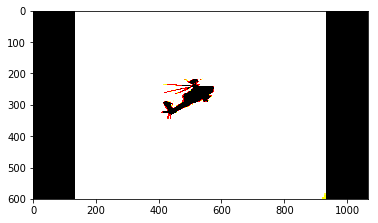

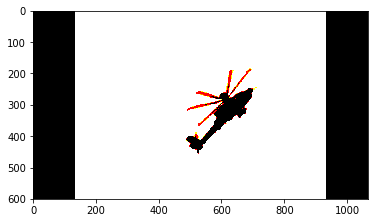

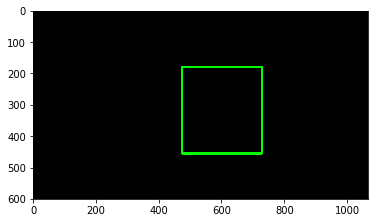

In [17]:
img = im_data_1[0].cpu().numpy()
plt.imshow(img.transpose(1,2,0))
plt.show()

img = im_data_2[0].cpu().numpy()
plt.imshow(img.transpose(1,2,0))
plt.show()

img = np.zeros(im_data_2[0].cpu().numpy().transpose(1,2,0).shape,dtype = np.uint8)
for it in range(target_gt_boxes.size(0)):
    tgt = target_gt_boxes[it,0,:]#.int()
    img = cv2.rectangle(img,(tgt[0],tgt[1]),(tgt[2],tgt[3]),(0,255,0),5)
plt.imshow(img)
plt.show()

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


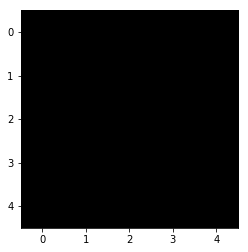

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


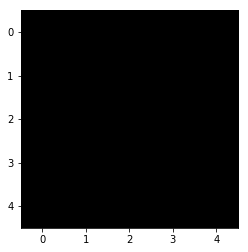

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


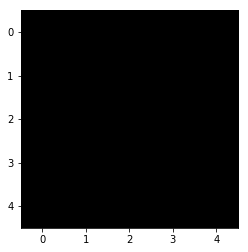

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


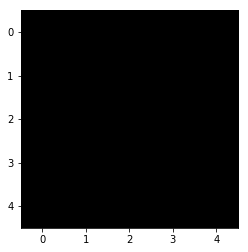

In [18]:
for idx in range(template_weights.size(0)):
    print(target_gt_boxes[idx,:,:])
    img = template_weights[idx,:,:,:].cpu().numpy()
    plt.imshow(img.transpose(1,2,0))
    plt.show()